In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [19]:
## Read in test image
mask_path = "10_kanugovimahidhar_mask.png"

image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
_, image_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

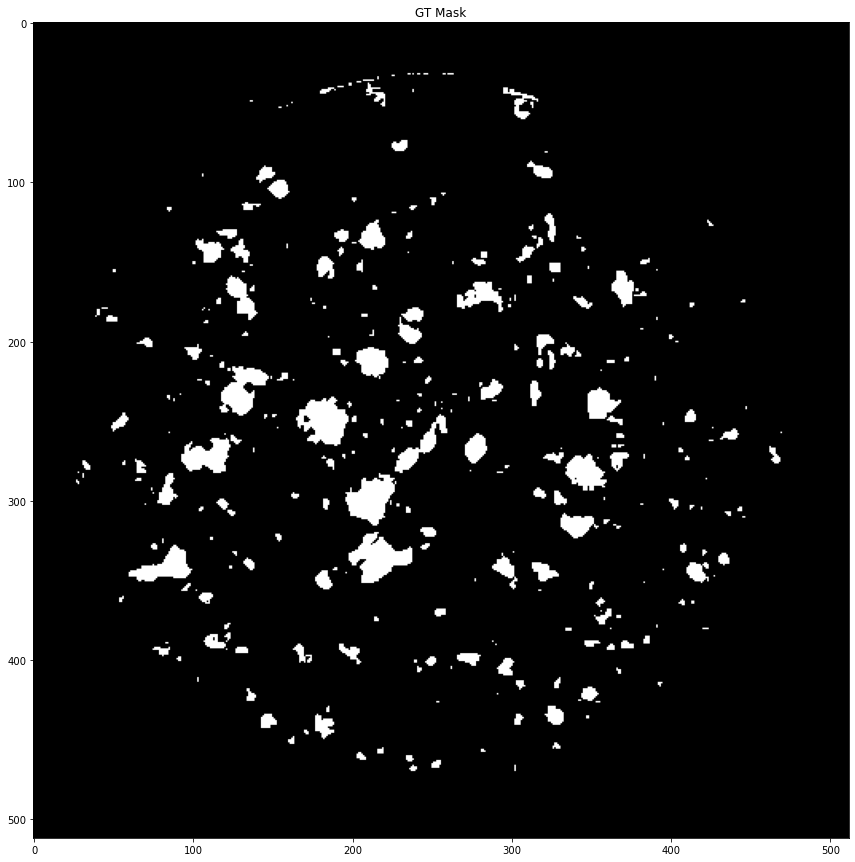

In [20]:
plt.figure(figsize=(15,15))
plt.title("GT Mask")
plt.imshow(image_thresh, cmap = 'gray')

In [21]:
## Get CCs
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(image_thresh)

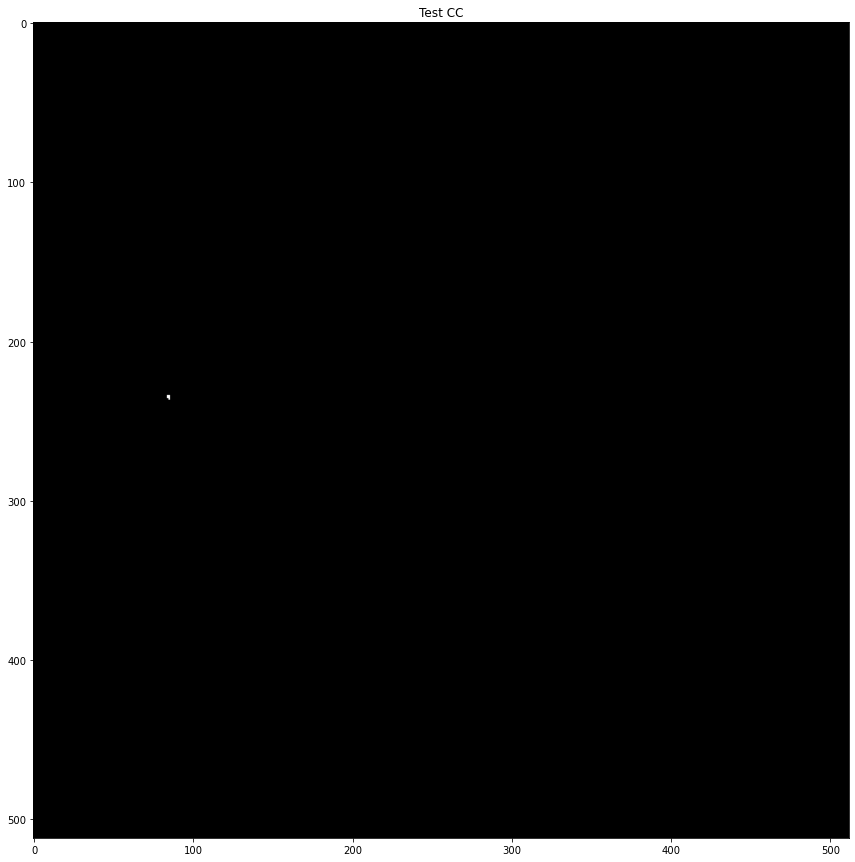

In [56]:
# Index of CC to test on
index = 136

# index = 43

test_cc = np.zeros_like(labels)
test_cc = np.where(labels == index, 255, 0).astype('uint8')

plt.figure(figsize=(15,15))
plt.title("Test CC")
plt.imshow(test_cc, cmap = 'gray')

In [6]:
## CC stats has x, y, w, h and area of each CC
x = stats[index][0]
y = stats[index][1]
w = stats[index][2]
h = stats[index][3]

# Get center of CC and convert to int
ct = centroids[index]
ct = np.array( [int(ct[0]), int(ct[1])] )

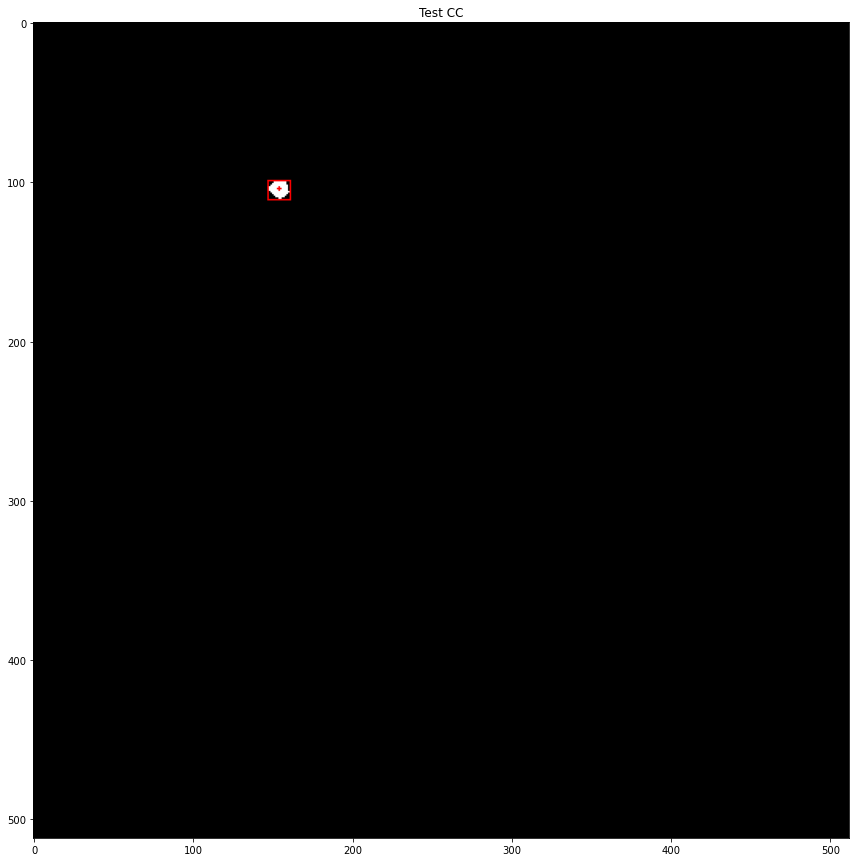

In [7]:
## Draw bbox and center of the CC
test_rgb = cv2.cvtColor(test_cc, cv2.COLOR_GRAY2RGB)

cv2.rectangle(test_rgb, (x, y), (x+w, y+h), color = [255, 0, 0], thickness = 1)
cv2.circle(test_rgb, ct, radius = 1, color = [255, 0, 0], thickness = -1)

plt.figure(figsize=(15,15))
plt.title("Test CC")
plt.imshow(test_rgb)

### Generate Gaussian heatmap

In [8]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

In [9]:
def gaussian_radius(det_size, min_overlap = 0.7):
    
    height, width = det_size
    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2
    
    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2
    
    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    
    return min(r1, r2, r3)
#     return max(r1, r2, r3)

In [10]:
def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma = diameter / 6)
    
    x, y = int(center[0]), int(center[1])
    
    height, width = heatmap.shape[0:2]
    
    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    
    return heatmap

In [11]:
empty_heat_map = np.zeros_like(test_cc).astype("float64")

radius = gaussian_radius((math.ceil(h), math.ceil(w)), min_overlap = 0.7)
radius = max(0, int(radius))

#SAMI stuff
# radius = math.ceil(radius*0.5)

heat_map = draw_umich_gaussian(empty_heat_map, ct, radius )

In [12]:
print(heat_map.shape)

(512, 512)


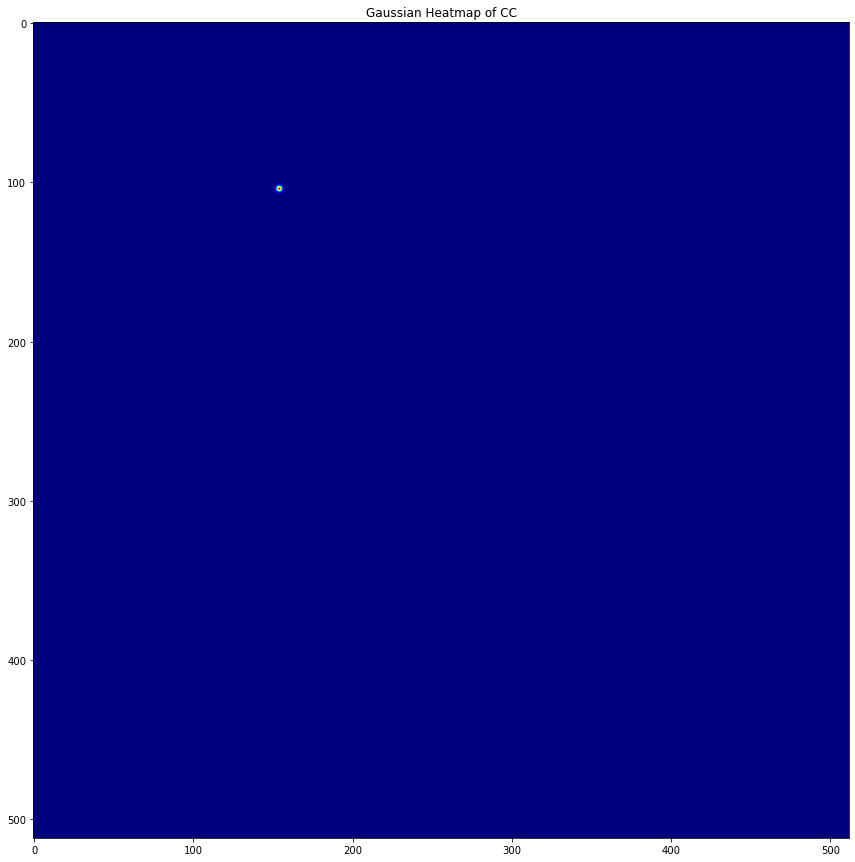

In [13]:
plt.figure(figsize=(15,15))
plt.title("Gaussian Heatmap of CC")
plt.imshow(heat_map, cmap = 'jet')

### Overlay heatmap on CC image

In [14]:
test_rgb_2 = cv2.cvtColor(test_cc, cv2.COLOR_GRAY2RGB)

<function matplotlib.pyplot.show(close=None, block=None)>

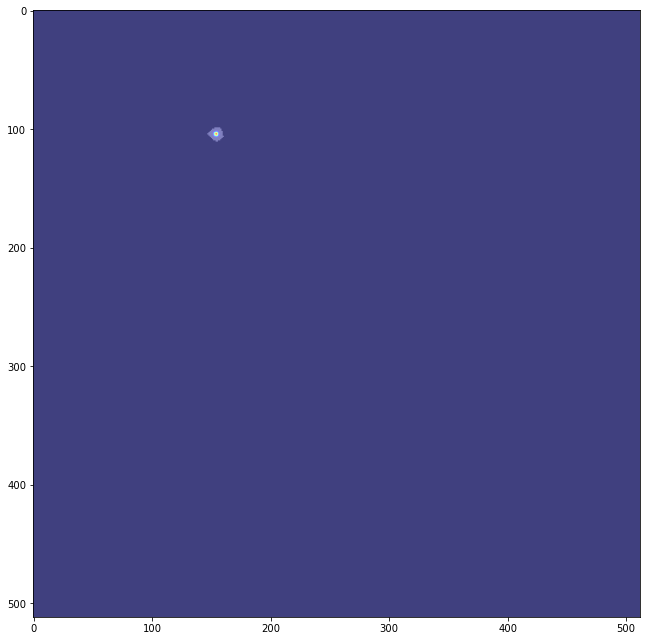

In [15]:
plt.figure(figsize=(50, 50))

ax2 = plt.subplot(1, 4, 3, aspect='equal')
ax2.imshow(np.squeeze(test_rgb_2), alpha = 0.5, cmap='jet')
hm = ax2.imshow(heat_map, alpha = 0.5, cmap = 'jet')
plt.show

In [16]:
mask = np.zeros_like(test_cc).astype("float64")
mask = np.where(test_cc>0, 1.0, 0.0)

masked_heat_map = mask*heat_map

<function matplotlib.pyplot.show(close=None, block=None)>

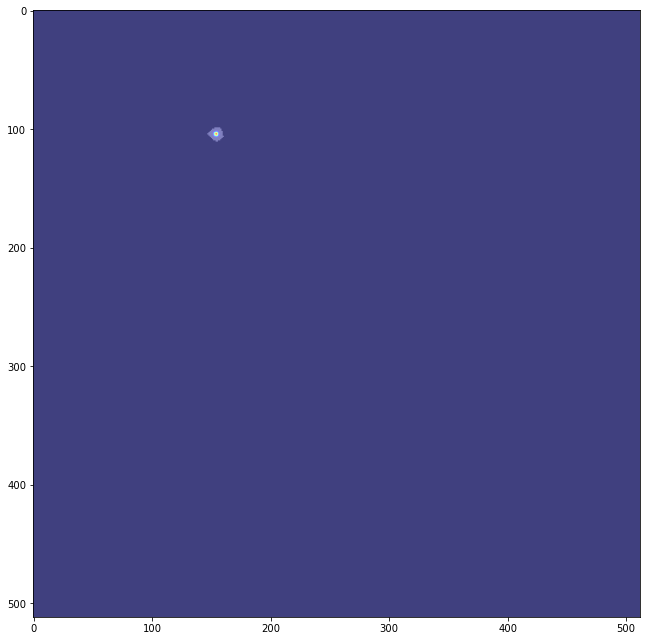

In [17]:
plt.figure(figsize=(50, 50))

ax2 = plt.subplot(1, 4, 3, aspect='equal')
ax2.imshow(np.squeeze(test_rgb_2), alpha = 0.5, cmap='jet')
hm = ax2.imshow(masked_heat_map, alpha = 0.5, cmap = 'jet')
plt.show

In [18]:
print(np.max(masked_heat_map))
print(np.min(masked_heat_map))

1.0
0.0
